In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from scipy.stats import mstats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [238]:
import pandas as pd
from sklearn.utils import shuffle

# Assuming your dataset is stored in a DataFrame called 'df'
# First, separate records with target variable 0 and 1
df_0 = df[df['Status'] == 0]
df_1 = df[df['Status'] == 1]

# Randomly select 22238 records from df_0
df_0_sampled = df_0.sample(n=20493, random_state=42)

# Randomly select the remaining records from df_1
n_remaining = 40000 - 20493
df_1_sampled = df_1.sample(n=n_remaining, random_state=42)

# Shuffle the sampled dataframes
df_0_sampled = shuffle(df_0_sampled, random_state=42)
df_1_sampled = shuffle(df_1_sampled, random_state=42)

# Concatenate the sampled dataframes
balanced_dataset = pd.concat([df_0_sampled, df_1_sampled])

# Shuffle the dataset
balanced_dataset = shuffle(balanced_dataset, random_state=42).reset_index(drop=True)

balanced_dataset.to_csv("Loan_Default_Data_1.csv", index = False)

### EDA and Preprocessing

In [240]:
# Reading the dataframe
df = pd.read_csv("Loan_Default_Data_1.csv")
df.head()


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status
0,104443,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,3840.0,EQUI,717,EXP,45-54,not_inst,NaN,south,direct,1
1,54497,2019,NaN,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,4020.0,EXP,559,EXP,65-74,not_inst,79.682274,south,direct,0
2,152659,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,9660.0,EQUI,577,EXP,25-34,not_inst,NaN,south,direct,1
3,146066,2019,cf,Sex Not Available,nopre,type1,p4,l1,nopc,nob/c,...,7680.0,CRIF,662,CIB,45-54,to_inst,70.502645,south,direct,0
4,157036,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,1320.0,EXP,548,CIB,55-64,to_inst,54.213483,North,direct,1


In [241]:
# Checking Number of rows and columns
df.shape

(40000, 33)

In [242]:
# Checking Number of unique rows in each column
df.nunique()

ID                           40000
year                             1
loan_limit                       2
Gender                           4
approv_in_adv                    2
loan_type                        3
loan_purpose                     4
Credit_Worthiness                2
open_credit                      2
business_or_commercial           2
loan_amount                    190
rate_of_interest                92
Interest_rate_spread         12373
Upfront_charges              12933
term                            24
Neg_ammortization                2
interest_only                    2
lump_sum_payment                 2
property_value                 304
construction_type                2
occupancy_type                   3
Secured_by                       2
total_units                      4
income                         703
credit_type                      4
Credit_Score                   401
co-applicant_credit_type         2
age                              7
submission_of_applic

1. Similarly, the ID column has 40000 unique records, which are the total number of rows, hence it is not significant for our model.
2. It can be observed that the 'year' column has only one unique value, which is 2019. Since the data is of only one year, we can exclude this column for our model.

In [243]:
# Dropping 'year' and 'ID' columns
df.drop(columns=['year', 'ID'], axis = 1, inplace = True)
df.columns

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'construction_type',
       'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status'],
      dtype='object')

In [244]:
# Checking info of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_limit                 39071 non-null  object 
 1   Gender                     40000 non-null  object 
 2   approv_in_adv              39755 non-null  object 
 3   loan_type                  40000 non-null  object 
 4   loan_purpose               39967 non-null  object 
 5   Credit_Worthiness          40000 non-null  object 
 6   open_credit                40000 non-null  object 
 7   business_or_commercial     40000 non-null  object 
 8   loan_amount                40000 non-null  int64  
 9   rate_of_interest           20599 non-null  float64
 10  Interest_rate_spread       20493 non-null  float64
 11  Upfront_charges            19998 non-null  float64
 12  term                       39988 non-null  float64
 13  Neg_ammortization          39968 non-null  obj

1. There are both categorical columns with type = 'object' and numeric columns.
2. Many columns show lesser non-null records than the total number of rows (40,000), hence, these null values need to be handled.

In [245]:
# Storing numerical and categorical columns into new variables for easier use
cat_cols = []
num_cols = []
for i in df.columns:
    if(df[i].dtype == "object"):
        cat_cols.append(i)
    else:
        num_cols.append(i)
print(f"Categorical Columns:\n {cat_cols}\n")
print(f"Number of Categorical columns: {len(cat_cols)}\n")
print(f"Numerical Columns:\n {num_cols}\n")
print(f"Number of Categorical columns: {len(num_cols)}")

Categorical Columns:
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']

Number of Categorical columns: 21

Numerical Columns:
 ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status']

Number of Categorical columns: 10


In [246]:
# 'Status' is our target variable and is already encoded as 0 & 1, hence it need not be considered as a numerical variable
# Thus, dropping status from our numerical columns and creating df_target for the 'Status' column

num_cols = num_cols[:-1]
print(f'Numeric Columns: {num_cols}')

df_target = df['Status'].copy()
df_target.head()

Numeric Columns: ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV']


0    1
1    0
2    1
3    0
4    1
Name: Status, dtype: int64

Dealing with Categorical Columns

In [247]:
# Checking value counts for each categorical variable
for i in cat_cols:
    print(f"{i}:\n{df[i].value_counts()}")

loan_limit:
cf     36015
ncf     3056
Name: loan_limit, dtype: int64
Gender:
Male                 11521
Sex Not Available    10532
Joint                10424
Female                7523
Name: Gender, dtype: int64
approv_in_adv:
nopre    33743
pre       6012
Name: approv_in_adv, dtype: int64
loan_type:
type1    29668
type2     6369
type3     3963
Name: loan_type, dtype: int64
loan_purpose:
p3    15139
p4    14359
p1     9465
p2     1004
Name: loan_purpose, dtype: int64
Credit_Worthiness:
l1    38117
l2     1883
Name: Credit_Worthiness, dtype: int64
open_credit:
nopc    39868
opc       132
Name: open_credit, dtype: int64
business_or_commercial:
nob/c    33631
b/c       6369
Name: business_or_commercial, dtype: int64
Neg_ammortization:
not_neg    34883
neg_amm     5085
Name: Neg_ammortization, dtype: int64
interest_only:
not_int     37985
int_only     2015
Name: interest_only, dtype: int64
lump_sum_payment:
not_lpsm    38436
lpsm         1564
Name: lump_sum_payment, dtype: int64
constructi

In [248]:
# Checking number of null values in categorical columns
df[cat_cols].isnull().sum()

loan_limit                   929
Gender                         0
approv_in_adv                245
loan_type                      0
loan_purpose                  33
Credit_Worthiness              0
open_credit                    0
business_or_commercial         0
Neg_ammortization             32
interest_only                  0
lump_sum_payment               0
construction_type              0
occupancy_type                 0
Secured_by                     0
total_units                    0
credit_type                    0
co-applicant_credit_type       0
age                          106
submission_of_application    106
Region                         0
Security_Type                  0
dtype: int64

In [249]:
# Imputing categorical variables with their mode
df_cat = df[cat_cols].copy()
for i in cat_cols:
    mode = df[i].mode()[0]
    df_cat.loc[:, i].fillna(mode, inplace = True)

df_cat.isnull().sum()


loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
credit_type                  0
co-applicant_credit_type     0
age                          0
submission_of_application    0
Region                       0
Security_Type                0
dtype: int64

In [250]:
# Encoding categorical columns
label = LabelEncoder()
for i in cat_cols:
    if df_cat[i].dtype == 'object':
        df_cat[i] = label.fit_transform(df_cat[i])

df_cat.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,Neg_ammortization,interest_only,...,construction_type,occupancy_type,Secured_by,total_units,credit_type,co-applicant_credit_type,age,submission_of_application,Region,Security_Type
0,0,0,0,0,3,0,0,1,0,1,...,1,1,0,0,2,1,2,0,3,1
1,0,3,0,0,0,0,0,1,1,1,...,1,0,0,0,3,1,4,0,3,1
2,0,2,0,0,0,0,0,1,0,1,...,1,1,0,0,2,1,0,0,3,1
3,0,3,0,0,3,0,0,1,1,1,...,1,1,0,0,1,0,2,1,3,1
4,0,2,0,0,3,0,0,1,0,1,...,1,1,0,0,3,0,3,1,0,1


Dealing with Numeric Columns

In [251]:
# Describing numerical columns
df_num = df[num_cols].copy()
df_num.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV
count,4.000000e+04,20599.000000,20493.000000,19998.000000,39988.000000,3.190700e+04,37861.000000,40000.000000,31907.000000
mean,3.270810e+05,4.042566,0.439894,3241.837135,335.323522,4.902562e+05,6682.644410,700.109100,73.905855
std,1.917778e+05,0.559612,0.514733,3244.461692,57.927970,3.943029e+05,6790.843637,116.400923,66.874064
min,1.650000e+04,2.250000,-1.046200,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478
25%,1.865000e+05,3.625000,0.071200,541.712500,360.000000,2.580000e+05,3480.000000,599.000000,60.980182
50%,2.865000e+05,3.990000,0.390000,2617.465000,360.000000,4.080000e+05,5400.000000,700.000000,75.887574
75%,4.265000e+05,4.375000,0.775900,4871.937500,360.000000,6.080000e+05,8160.000000,801.000000,87.347561
max,3.576500e+06,7.375000,2.885400,38437.500000,360.000000,1.650800e+07,377220.000000,900.000000,7831.250000


In [252]:
# Checking for null values in each column
df_num.isnull().sum()

loan_amount                 0
rate_of_interest        19401
Interest_rate_spread    19507
Upfront_charges         20002
term                       12
property_value           8093
income                   2139
Credit_Score                0
LTV                      8093
dtype: int64

In [253]:
# Imputing missing values of numerical columns through KNN imputer
knn = KNNImputer(n_neighbors = 3)
knn.fit(df_num)
X = knn.fit_transform(df_num)
df_num = pd.DataFrame(X, columns=num_cols)
df_num.isnull().sum()

loan_amount             0
rate_of_interest        0
Interest_rate_spread    0
Upfront_charges         0
term                    0
property_value          0
income                  0
Credit_Score            0
LTV                     0
dtype: int64

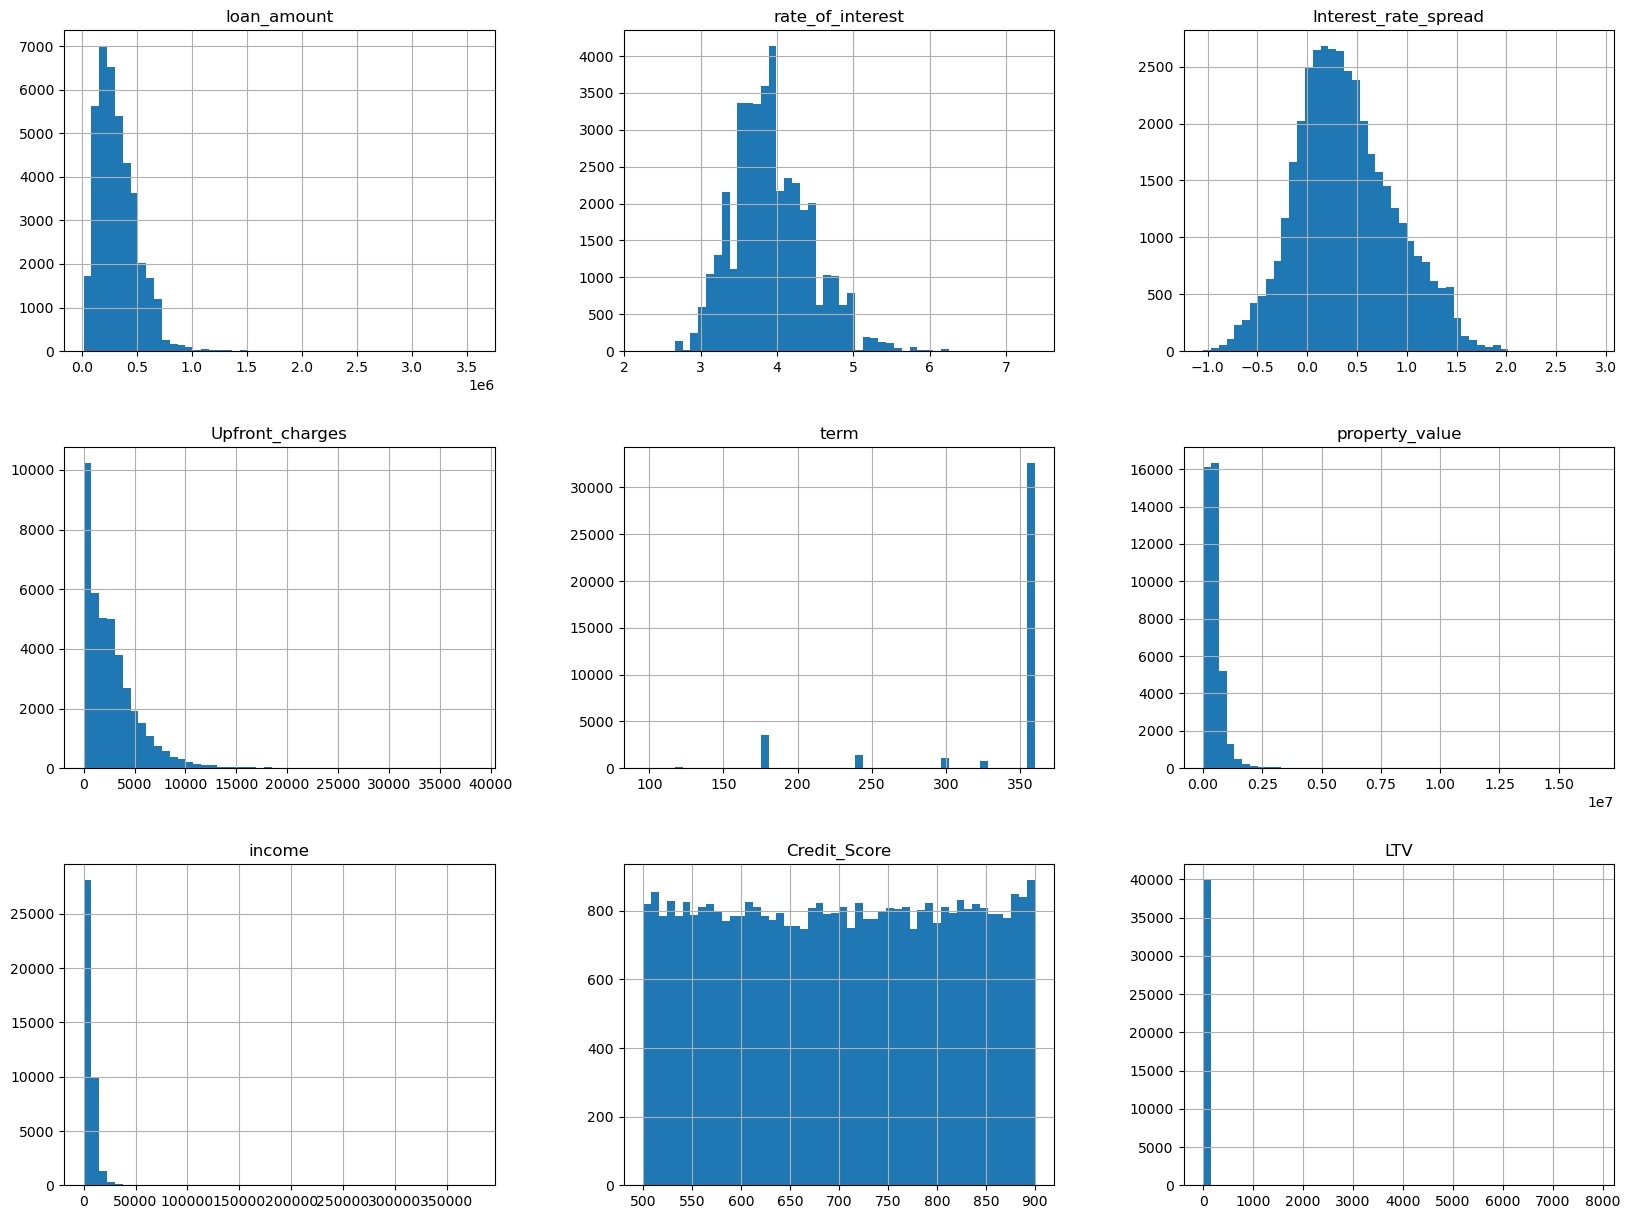

In [254]:
# Histograms for numeric columns
df_num.hist(bins=50,figsize=(20,15))
plt.show()

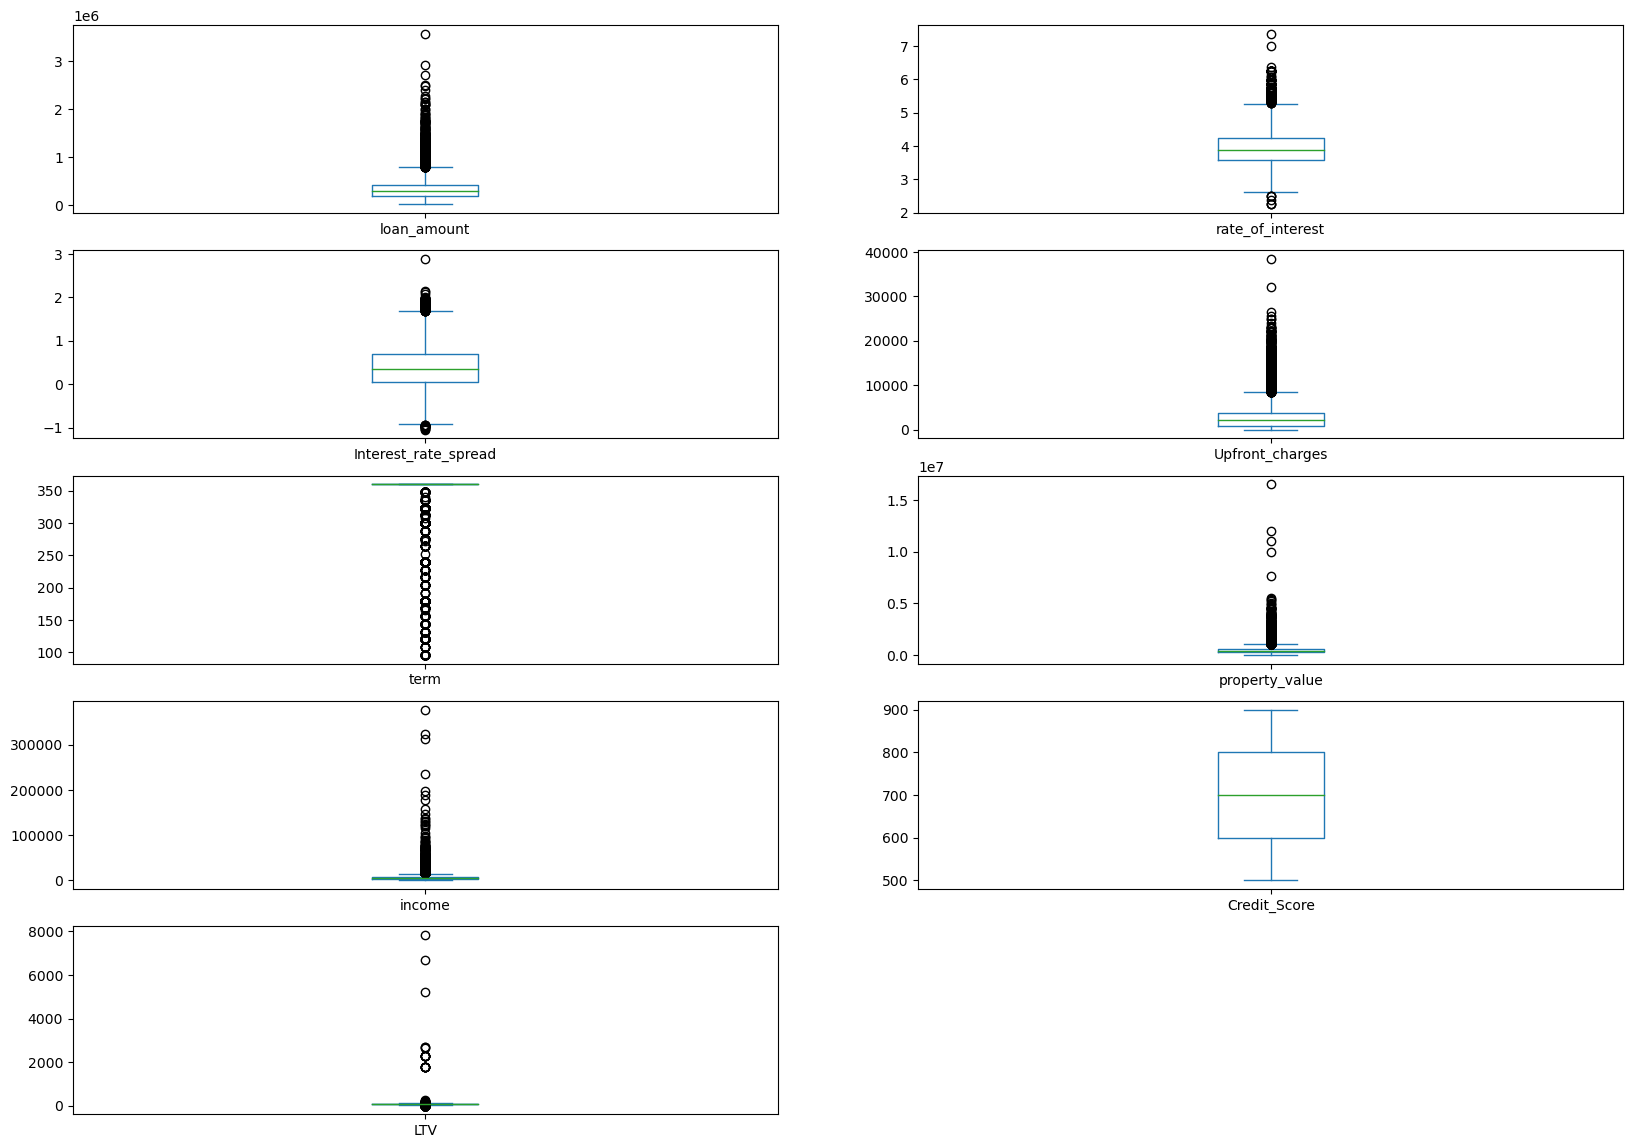

In [255]:
# Box plot for numerical columns to study outliers
df_num.plot(kind="box",subplots=True,layout=(7,2),figsize=(20,20))
plt.show()

In [256]:
# Removing Outliers
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    upper_bound = iqr + np.percentile(df[field_name], 75)
    lower_bound = np.percentile(df[field_name], 25) - iqr

    if ((df[field_name] > upper_bound) | (df[field_name] < lower_bound)).empty:
        print("No outliers to drop.")
        return

    df.drop(df[(df[field_name] > upper_bound) | (df[field_name] < lower_bound)].index, inplace=True)


df_num_copy = df_num.copy()
drop_outliers(df_num_copy, "loan_amount")
drop_outliers(df_num_copy, "rate_of_interest")
drop_outliers(df_num_copy, "Interest_rate_spread")
drop_outliers(df_num_copy, "Upfront_charges")
drop_outliers(df_num_copy, "property_value")
drop_outliers(df_num_copy, "income")
drop_outliers(df_num_copy, "LTV")
drop_outliers(df_num_copy, "term")


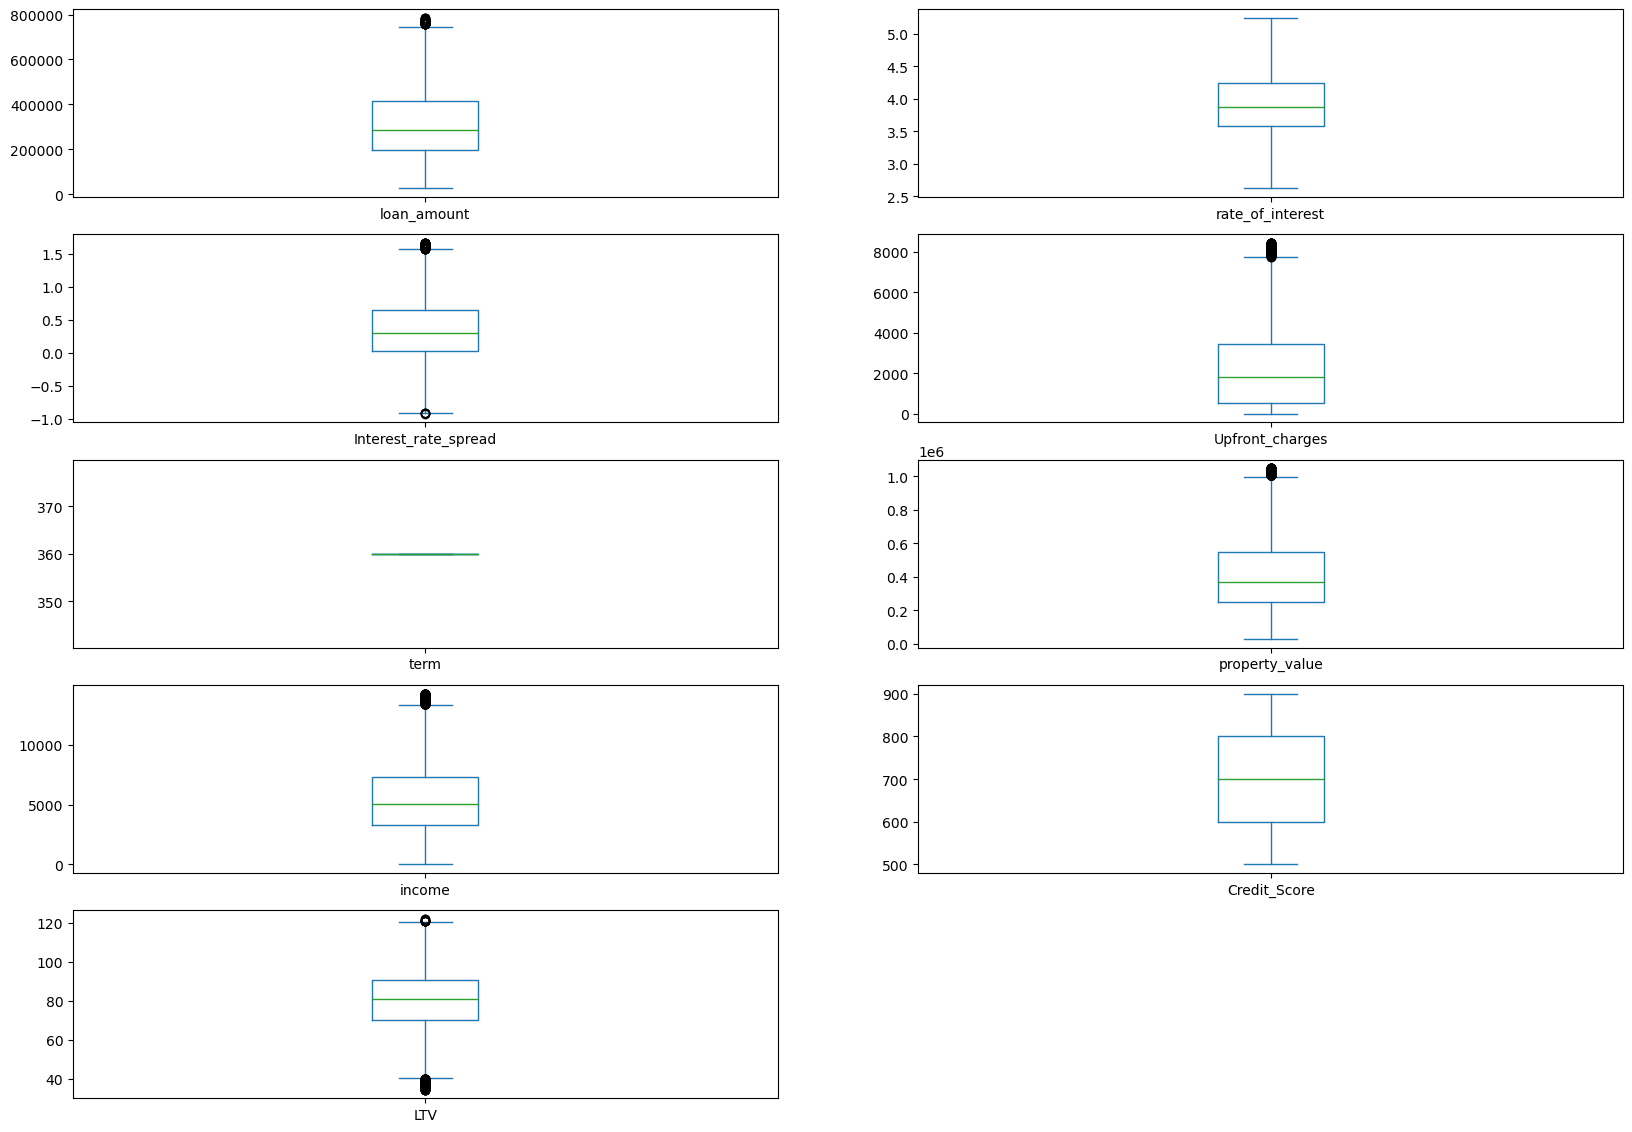

In [257]:
# Box plots after removing outliers
df_num_copy.plot(kind="box",subplots=True,layout=(7,2),figsize=(20,20))
plt.show()

In [258]:
# Checking shape of dataframe after removing outliers
df_num_copy.shape

(27676, 9)

In [259]:
# Winsorizing outliers
df_num_wins = df_num.copy()
for i in num_cols:
    df_num_wins[i] = mstats.winsorize(df_num_wins[i], limits = [0.05, 0.05])


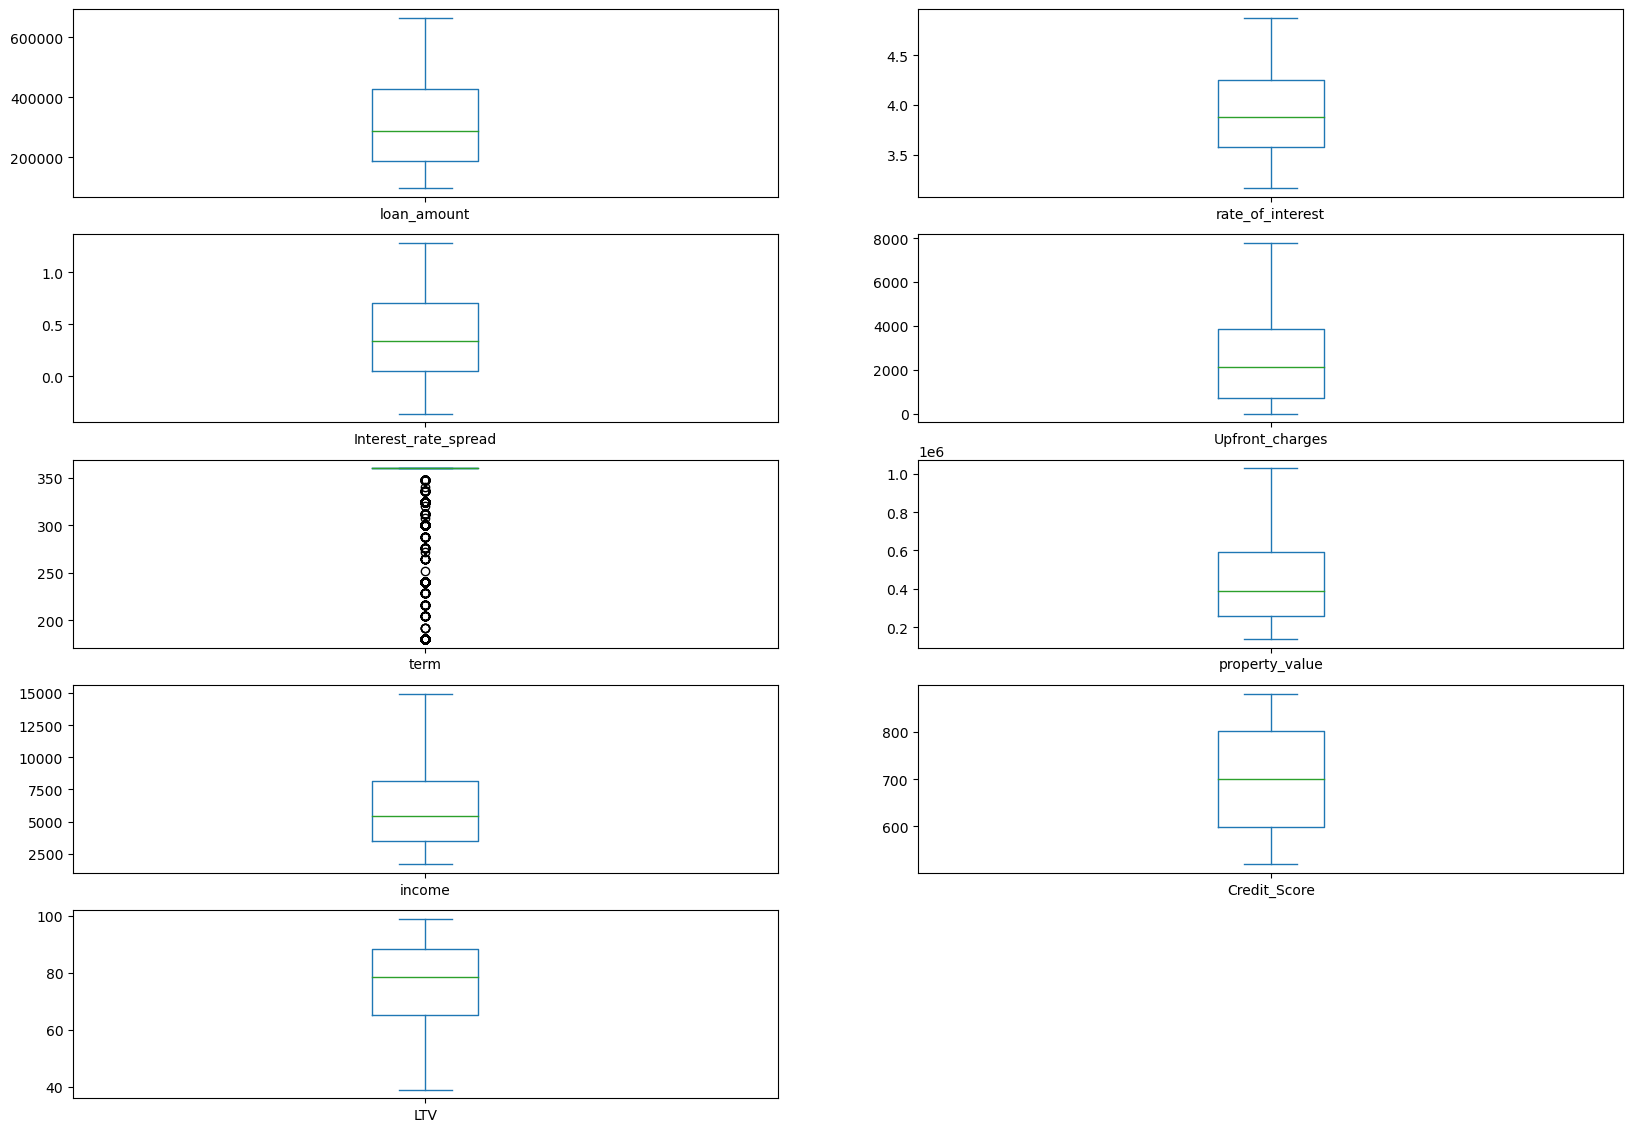

In [260]:
# Box plot after winsorizing
df_num_wins.plot(kind="box",subplots=True,layout=(7,2),figsize=(20,20))
plt.show()

In [261]:
# Checking number of outliers in the 'term' column
term_values = df_num_wins['term'].values.data
Q1 = np.quantile(term_values, 0.25)
Q3 = np.quantile(term_values, 0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_count = ((term_values < lower_bound) | (term_values > upper_bound)).sum()
print("Number of outliers in 'term' column:", outliers_count)

Number of outliers in 'term' column: 7352


In [262]:
# Since the number of outliers in the 'term' column is still large, we will winsorize it from 'df_num' again with 0.10 limits
df_num_wins['term'] = mstats.winsorize(df_num['term'], limits = [0.20, 0])

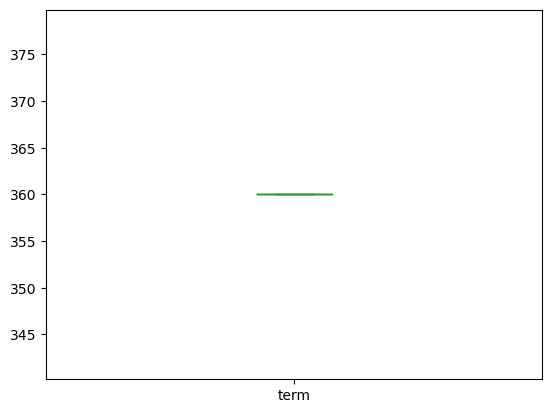

In [263]:
# Checking boxplot of the 'term' column again after winsorizing
df_num_wins['term'].plot(kind="box")
plt.show()

Thus, 'df_num_wins' is the final cleaned dataset with no null values or outliers.
Hence, we will now merge the cleaned categorical dataset, df_cat with df_num_wins to get the complete dataset of all features.

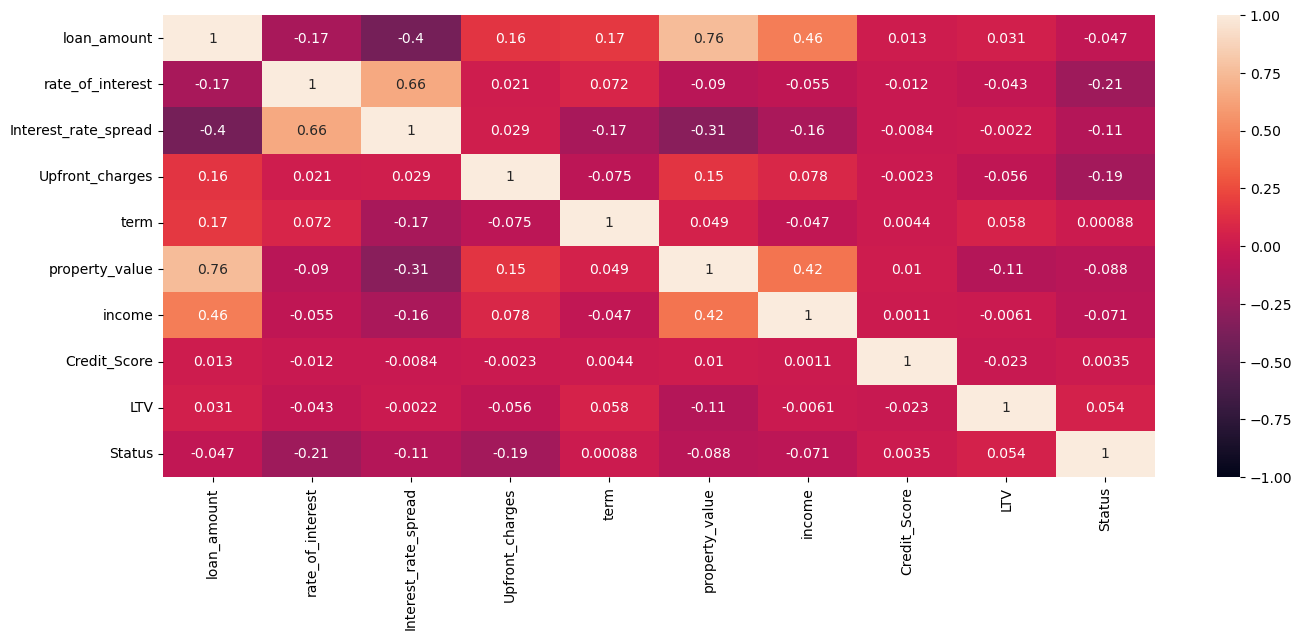

In [264]:
# Checking correlation of numerical data with the target variable and with each other for multicollinearity
corr_data = pd.concat([df_num, df_target], axis=1)
plt.figure(figsize=(16, 6))
sns.heatmap(data = corr_data.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Merging Numerical and Categorical data after cleaning

In [265]:
df_cat.shape

(40000, 21)

In [266]:
df_num_wins.shape

(40000, 9)

In [267]:
# Merging the categorical and numerical datasets together after cleaning
df_features = pd.concat([df_num_wins, df_cat], axis=1)
print(df_features.isnull().sum())
df_features.head()

loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
property_value               0
income                       0
Credit_Score                 0
LTV                          0
loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
credit_type                  0
co-applicant_credit_type     0
age                          0
submission_of_application    0
Region                       0
Security_Type                0
dtype: int64


,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,loan_limit,...,construction_type,occupancy_type,Secured_by,total_units,credit_type,co-applicant_credit_type,age,submission_of_application,Region,Security_Type
0,326500.0,3.250000,0.120700,0.000000,360.0,488000.0,3840.0,717.0,72.667377,0,...,1,1,0,0,2,1,2,0,3,1
1,476500.0,4.875000,1.285067,7741.990000,360.0,598000.0,4020.0,559.0,79.682274,0,...,1,0,0,0,3,1,4,0,3,1
2,666500.0,4.291667,0.419400,7781.130000,360.0,1028000.0,9660.0,577.0,71.005733,0,...,1,1,0,0,2,1,0,0,3,1
3,266500.0,3.375000,0.490300,7781.130000,360.0,378000.0,7680.0,662.0,70.502645,0,...,1,1,0,0,1,0,2,1,3,1
4,96500.0,4.455000,1.109300,2510.643333,360.0,178000.0,1680.0,548.0,54.213483,0,...,1,1,0,0,3,0,3,1,0,1


### Train Test Split

In [340]:
# Creating full dataframe with cleaned numerical and categorical variables along with the target
df_full = pd.concat([df_cat, df_num_wins,df_target], axis = 1)

# Splitting training and testing datasets
train_set, test_set = train_test_split(df_full, test_size=0.3, random_state=42)

y_train = train_set['Status']
X_train = train_set.drop(columns=['Status'])
y_test = test_set['Status']
X_test = test_set.drop(columns=['Status'])

In [269]:
# Checking shape of training and testing datasets
print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (28000, 30)
Shape of y_train:  (28000,)
Shape of x_test:  (12000, 30)
Shape of y_test:  (12000,)


### Basic Model - Logistic Regression (Binary class classification)

In [270]:
# Checking value_counts of target variable
df_full['Status'].value_counts()

0    20493
1    19507
Name: Status, dtype: int64

The class of 'Status' is fairly balanced

In [284]:
# Fitting the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [325]:
# Making predictions on training data
train_pred_logit = lr.predict(X_train)
print(classification_report(y_train, train_pred_logit))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61     14343
           1       0.60      0.64      0.62     13657

    accuracy                           0.62     28000
   macro avg       0.62      0.62      0.62     28000
weighted avg       0.62      0.62      0.62     28000



In [326]:
# Making predictions on testing data
test_pred_logit = lr.predict(X_test)
print(classification_report(y_test, test_pred_logit))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62      6150
           1       0.61      0.64      0.62      5850

    accuracy                           0.62     12000
   macro avg       0.62      0.62      0.62     12000
weighted avg       0.62      0.62      0.62     12000



Both training and testing predictions do not show a good accuracy.
Hence, trying out different methods.

1. Transforming numerical variables polynomially as their correlation with the 'Status' column indicates weakness

In [360]:
# Transforming numerical columns to polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_full[num_cols])
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(num_cols))
df_full.reset_index(drop=True, inplace=True)
poly_features_df.reset_index(drop=True, inplace=True)
df_full_poly = pd.concat([df_full.drop(num_cols, axis=1), poly_features_df], axis=1)
df_full_poly.reset_index(drop=True, inplace=True)


In [361]:
# Train-test-split on df with polynomial numerical features
train_set_poly, test_set_poly = train_test_split(df_full_poly, test_size=0.3, random_state=42)

y_train_poly = train_set_poly['Status']
X_train_poly = train_set_poly.drop(columns=['Status'])
y_test_poly = test_set_poly['Status']
X_test_poly = test_set_poly.drop(columns=['Status'])

In [362]:
# Fitting the model
logreg_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000))
logreg_pipeline.fit(X_train_poly, y_train_poly)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [363]:
# Making predictions on training data
train_pred_logit_poly = logreg_pipeline.predict(X_train_poly)
print(classification_report(y_train_poly, train_pred_logit_poly))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79     14343
           1       0.77      0.78      0.78     13657

    accuracy                           0.78     28000
   macro avg       0.78      0.78      0.78     28000
weighted avg       0.78      0.78      0.78     28000



In [364]:
# Making predictions on testing data
test_pred_logit_poly = lr.predict(X_test_poly)
print(classification_report(y_test_poly, test_pred_logit_poly))

              precision    recall  f1-score   support

           0       0.59      0.73      0.66      6150
           1       0.63      0.47      0.54      5850

    accuracy                           0.61     12000
   macro avg       0.61      0.60      0.60     12000
weighted avg       0.61      0.61      0.60     12000



After converting features to polynomial, there is overfitting observed, hence performing GridCV with L2 and fitting with best parameters.

In [370]:
# Fitting the model
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='lbfgs', max_iter=1000))
])
logreg_pipeline.fit(X_train_poly, y_train_poly)

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'logreg__penalty': ['l2']
}

grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_poly, y_train_poly)

print('Train Set Classification Report:')
train_pred_logit_poly = grid_search.best_estimator_.predict(X_train_poly)
print(classification_report(y_train_poly, train_pred_logit_poly))

print('\n Test Set Classification Report')
test_pred_logit_poly = grid_search.best_estimator_.predict(X_test_poly)
print(classification_report(y_test_poly, test_pred_logit_poly))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Train Set Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79     14343
           1       0.77      0.78      0.78     13657

    accuracy                           0.78     28000
   macro avg       0.78      0.78      0.78     28000
weighted avg       0.78      0.78      0.78     28000


 Test Set Classification Report
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      6150
           1       0.78      0.78      0.78      5850

    accuracy                           0.78     12000
   macro avg       0.78      0.78      0.78     12000
weighted avg       0.78      0.78      0.78     12000



GridCV search with Ridge reduces overfitting. However, the model still isn't receiving optimal results, hence trying other models.

### Random Forest Classification

In [296]:
# Fitting data on Random Forest Classifier Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [327]:
# Making predictions on training data
train_pred_rf = rf_model.predict(X_train)
print(classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14343
           1       1.00      1.00      1.00     13657

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000



In [328]:
# Making predictions on testing data
test_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6150
           1       0.92      0.86      0.89      5850

    accuracy                           0.89     12000
   macro avg       0.90      0.89      0.89     12000
weighted avg       0.90      0.89      0.89     12000



The training dataset shows a perfect accuracy of 1 where as the testing dataset shows an accuracy of 0.89. Thus, the model is overfitting. Hence, changing hyperparameters to address overfitting.

In [318]:
# Fitting Data
rf_model_2 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=5, random_state=42)
rf_model_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       random_state=42)

In [329]:
# Making predictions on training data
train_pred_rf = rf_model_2.predict(X_train)
print(classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     14343
           1       0.93      0.81      0.87     13657

    accuracy                           0.88     28000
   macro avg       0.88      0.88      0.88     28000
weighted avg       0.88      0.88      0.88     28000



In [330]:
# Making predictions on testing data
test_pred_rf = rf_model_2.predict(X_test)
print(classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      6150
           1       0.90      0.79      0.84      5850

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



After hyperparameter tuning, the overfitting is accounted for.

### XG Boost Classification

In [321]:
# Fitting the model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [331]:
train_pred_xgb = xgb_model.predict(X_train)
print(classification_report(y_train, train_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14343
           1       1.00      0.97      0.98     13657

    accuracy                           0.98     28000
   macro avg       0.98      0.98      0.98     28000
weighted avg       0.98      0.98      0.98     28000



In [332]:
test_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, test_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6150
           1       0.98      0.94      0.96      5850

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



XG boost model is giving good results on both training and testing sets.

### Plotting ROC Curves and Checking AUC for each model

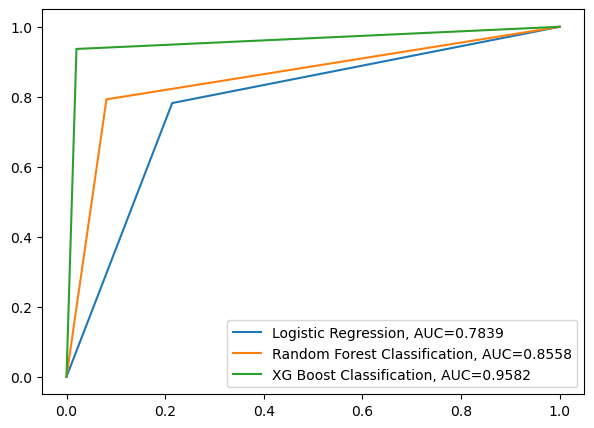

In [372]:
#Comparing the three best models using ROC and AUC
plt.figure(figsize = (7,5))

#ROC curve for Polynomial Logistic Regression model with Ridge  
fpr, tpr, _ = roc_curve(y_test, test_pred_logit_poly)
auc = round(roc_auc_score(y_test, test_pred_logit_poly), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#ROC curve for Hypertuned Random forest classifier
fpr, tpr, _ = roc_curve(y_test, test_pred_rf)
auc = round(roc_auc_score(y_test, test_pred_rf), 4)
plt.plot(fpr,tpr,label="Random Forest Classification, AUC="+str(auc))

#ROC curve for XGB classifier
fpr, tpr, _ = roc_curve(y_test, test_pred_xgb)
auc = round(roc_auc_score(y_test, test_pred_xgb), 4)
plt.plot(fpr,tpr,label="XG Boost Classification, AUC="+str(auc))

plt.legend()
plt.show()